# VAE analysis

In [2]:
import os.path
import numpy as np
import pandas as pd
import torch
import pickle
import subprocess
from matplotlib import pyplot as plt
from Bio import SeqIO
from importlib import reload
import warnings

from scipy.stats import mode
from sklearn.neighbors import KernelDensity
from skimage.graph import route_through_array
from scipy.spatial import cKDTree

import matplotlib.cm as cm

import minimal_version.parser_handler
%cd /Users/dahala/GitHub/VAE-enzymes/vae_notebooks/
from minimal_version.preprocess_msa import Preprocessor, weight_sequences
from minimal_version.msa import MSA
from minimal_version.utils import Capturing, store_to_pkl, store_to_fasta, load_from_pkl

from minimal_version.train import setup_train, Train

%cd /Users/dahala/GitHub/VAE-enzymes/
from custom_functions import *
%cd /Users/dahala/GitHub/VAE-enzymes/vae_notebooks/notebooks/

[WinError 3] The system cannot find the path specified: '/Users/dahala/GitHub/VAE-enzymes/vae_notebooks/'
c:\Users\dhard\GitHub\VAE-enzymes\vae_notebooks\notebooks


ModuleNotFoundError: No module named 'notebooks'

In [57]:
#CONFIGURATION_FILE = "msaCazy_GT1_trim_200_1000_GASPhmm.json"
CONFIGURATION_FILE = "msaCazy_GT1_trim_200_1000_charactNarch_lay400to200_ls100.json"
run = minimal_version.parser_handler.RunSetup(CONFIGURATION_FILE)
print(f" Working with {CONFIGURATION_FILE} configuration file!")
PFAM_INPUT = False

Configuration file stored in ../results/Cazy_GT1_trim_200_1000_charactNarch_lay400to200_ls100/config/2025-04-07_13-18.json
 Working with msaCazy_GT1_trim_200_1000_charactNarch_lay400to200_ls100.json configuration file!


In [58]:
HMMbuild = HMMmodule(run)
#HMMbuild.build()
#HMMbuild.align('GT1_ncbi_filtered_200_1000',fasta_ext='fasta', save_path=run.msa)

In [59]:
"""
Preprocess MSA and prepare it for VAE model training
"""

# logging
msa_log = open(os.path.join(run.logs, 'msa_log.txt'), "w")

# MSA loading
if PFAM_INPUT:
    msa = MSA.load_pfam(run.dataset)
else:
    msa = MSA.load_msa(run.dataset)
MSA.amino_acid_dict(run.pickles)
msg = f"MSA in {run.dataset} loaded\n" \
      f"number of sequences: {len(list(msa.keys()))}"
print(msg)
msa_log.write(msg + f'\n{"="*80}\n')

# MSA preprocessing
preprocessor = Preprocessor(run)
with Capturing() as output:
    msa, msa_keys = preprocessor.trim_msa(msa)
msa_log.write(" MSA Preprocessing \n" + "\n".join(output) + f'\n{"="*80}\n')
assert (msa.shape[0] == len(msa_keys))
trim_file_path = os.path.join(run.msa, "trimmed_msa.fasta")
msg = f"Trimmed MSA has {msa.shape[0]} sequences and the width is {msa.shape[1]}\n" \
      f"Trimmed MSA is stored at {trim_file_path}"
print(msg)
msa_log.write(msg + f'\n{"="*80}\n')
msa_num_dict_shuffled = {k: seq for k, seq in zip(msa_keys, msa)}  # transform to dictionary, have keys together
# but secure that query and fixed sequences are at the beginning 
msa_num_dict = {k: msa_num_dict_shuffled[k] for k in preprocessor.keep_keys}
msa_num_dict.update({k: msa_num_dict_shuffled[k] for k in msa_num_dict_shuffled if k not in preprocessor.keep_keys})

trimmed_msa = MSA.number_to_amino(msa_num_dict)
store_to_fasta(trimmed_msa, trim_file_path)
store_to_pkl({run.query: trimmed_msa[run.query]}, os.path.join(run.pickles, "reference_seq.pkl"))

# Filtering or weighting
with Capturing() as output:
    if run.clustering:  # MSA filtering
        print(f"MSA {run.identity}% identity filtering step")
        msa_num_dict = preprocessor.identity_filtering(msa_num_dict)
        msa, training_alg = preprocessor.get_keys_file_and_np_sequences(msa_num_dict)  # Overlap one treemmer
        seq_weight = np.ones(msa.shape[0])  # we just provide uniform weights for all sequences
    else:  # otherwise the weighting mechanism will be applied
        msa, training_alg = preprocessor.get_keys_file_and_np_sequences(msa_num_dict)  # Overlap one treemmer
        seq_weight = weight_sequences(msa)
msa_log.write("\n".join(output))
train_msa_file_path = os.path.join(run.msa, "training_msa.fasta")
training_alg = MSA.number_to_amino(training_alg)
store_to_fasta(training_alg, train_msa_file_path)
msg = f"Training MSA has {msa.shape[0]} sequences and the width is {msa.shape[1]}\n" \
      f"Training MSA is stored at {train_msa_file_path}"
print(msg)
msa_log.write(msg + f'\n{"=" * 80}\n')

store_to_pkl(seq_weight, os.path.join(run.pickles, "seq_weight.pkl"))
store_to_pkl(training_alg, os.path.join(run.pickles, "training_alignment.pkl"))

# MSA one-hot encoding
binary = MSA.number_to_binary(msa)
store_to_pkl(binary, os.path.join(run.pickles, "seq_msa_binary.pkl"))
msa_log.close()

MSA in ../results/Cazy_GT1_trim_200_1000_charactNarch_lay400to200_ls100/msa/GT1_ncbi_filtered_200_1000_fix.afa loaded
number of sequences: 50169
Trimmed MSA has 41801 sequences and the width is 403
Trimmed MSA is stored at ../results/Cazy_GT1_trim_200_1000_charactNarch_lay400to200_ls100/msa/trimmed_msa.fasta
Training MSA has 41801 sequences and the width is 403
Training MSA is stored at ../results/Cazy_GT1_trim_200_1000_charactNarch_lay400to200_ls100/msa/training_msa.fasta


In [60]:
with open(run.pickles+ "/msa_columns.pkl", "rb") as input_file:
   msa_columns = pickle.load(input_file)

In [61]:
load_from_pkl(os.path.join(run.model, "model_params.pkl"))['model']

'vae'

In [62]:
run.weights

'../results/Cazy_GT1_trim_200_1000_charactNarch_lay400to200_ls100/model/vae_fold_0.model'

/Users/dahala/GitHub/VAE-enzymes/vae_notebooks
/Users/dahala/GitHub/VAE-enzymes/vae_notebooks/notebooks


/Users/dahala/GitHub/VAE-enzymes/vae_notebooks/notebooks/minimal_version/latent_space.py:42: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  vae.load_state_dict(torch.load(sel

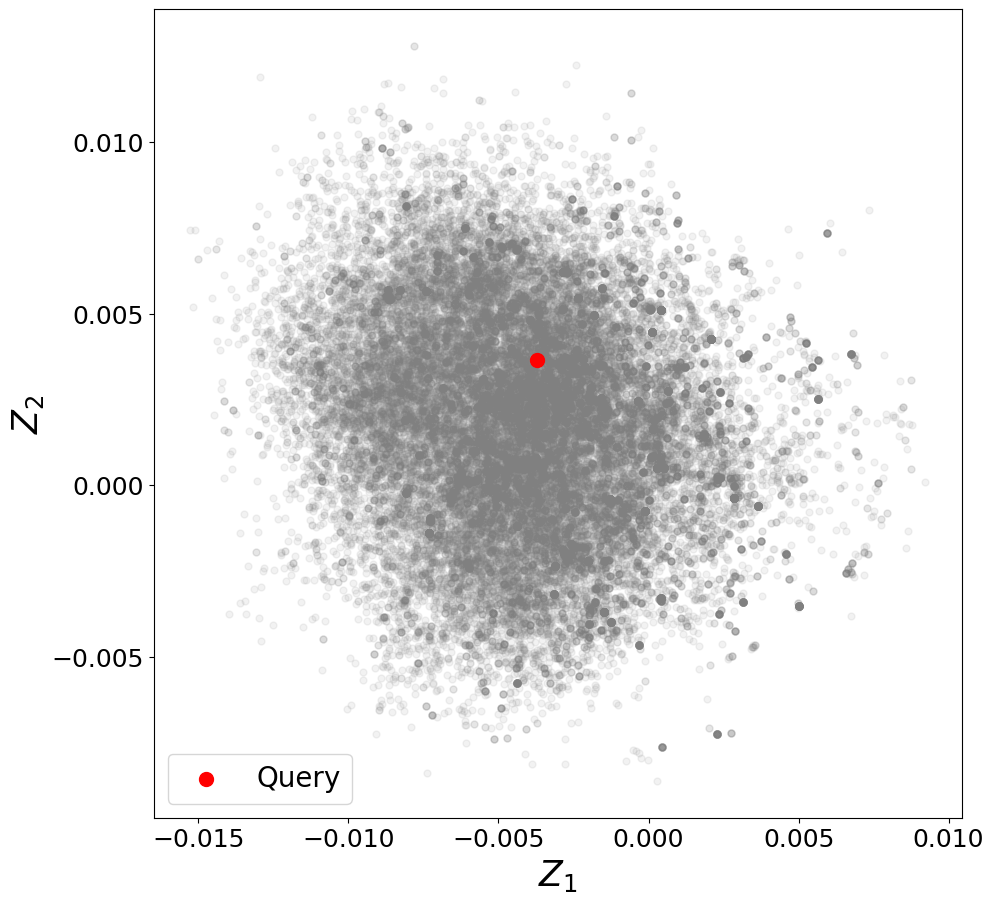

In [63]:
%cd /Users/dahala/GitHub/VAE-enzymes/vae_notebooks
from matplotlib import pyplot as plt
from notebooks.minimal_version.latent_space import LatentSpace
%cd /Users/dahala/GitHub/VAE-enzymes/vae_notebooks/notebooks/

# Projection to the latent space
# Show your queries
run.weights = f'{run.result}/model/vae_fold_0.model'
latent_space = LatentSpace(run)
msa_embeddings = latent_space.msa_embeddings["mus"]


query_coords = latent_space.key_to_embedding(run.fixed_sequences)


fig_lat, ax = plt.subplots(1, 1,figsize=(10,10))

ax.plot(msa_embeddings[:, 0], msa_embeddings[:, 1], '.', alpha=0.1, markersize=10, color='grey',zorder=0)
ax.scatter(query_coords[0], query_coords[1], marker='o', s=100, color='red', label='Query',zorder=1)

# Project 
ax.legend(loc='lower left', fontsize=20)
ax.tick_params(labelsize=18)
ax.set_xlabel(r'$Z_1$', fontsize=25)
ax.set_ylabel(r'$Z_2$', fontsize=25)
ax.set_box_aspect(1)

plt.tight_layout()
fig_lat.savefig(os.path.join(run.results, f"latent_space.png"))
    #ax.set_title(f"Latent space projection final")

/Users/dahala/GitHub/VAE-enzymes/vae_notebooks
/Users/dahala/GitHub/VAE-enzymes/vae_notebooks/notebooks


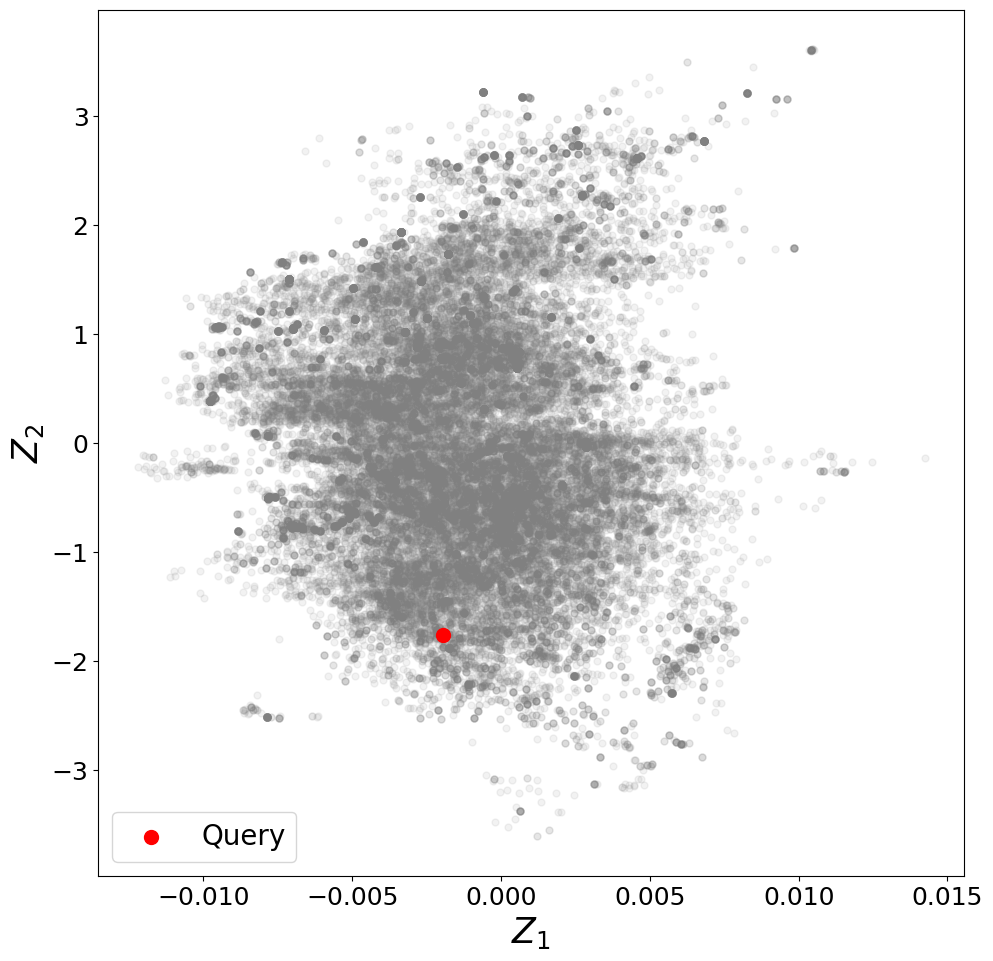

In [64]:
%cd /Users/dahala/GitHub/VAE-enzymes/vae_notebooks
from matplotlib import pyplot as plt
from notebooks.minimal_version.latent_space import LatentSpace
%cd /Users/dahala/GitHub/VAE-enzymes/vae_notebooks/notebooks/

# Projection to the latent space
# Show your queries
run.weights = f'{run.result}/model/vae_fold_0.model'
latent_space = LatentSpace(run)
msa_embeddings = latent_space.msa_embeddings["mus"]


query_coords = latent_space.key_to_embedding(run.fixed_sequences)


fig_lat, ax = plt.subplots(1, 1,figsize=(10,10))

ax.plot(msa_embeddings[:, 2], msa_embeddings[:, 3], '.', alpha=0.1, markersize=10, color='grey',zorder=0)
ax.scatter(query_coords[2], query_coords[3], marker='o', s=100, color='red', label='Query',zorder=1)

# Project 
ax.legend(loc='lower left', fontsize=20)
ax.tick_params(labelsize=18)
ax.set_xlabel(r'$Z_1$', fontsize=25)
ax.set_ylabel(r'$Z_2$', fontsize=25)
ax.set_box_aspect(1)

plt.tight_layout()
fig_lat.savefig(os.path.join(run.results, f"latent_space_z3_z4.png"))
    #ax.set_title(f"Latent space projection final")

In [65]:
HMMbuild.align('All_data_unique',fasta_ext='fasta',save_path=run.msa)

In [66]:
Dataset1 = SeqIO.to_dict(SeqIO.parse(f'{run.msa}/All_data_unique_fix.afa', 'fasta'))
Dataset1_seqs = []
Dataset1_seqs_msa_col = []
for acc, item in Dataset1.items():
    seq = str(item.seq)
    if len(seq) > 0:
        Dataset1_seqs.append(seq)
        msa_seq_ = ''.join([seq[s] for s in msa_columns])
        Dataset1_seqs_msa_col.append(msa_seq_)
    else:
        print(f"⚠ Empty sequence for {acc}")
# Encode all sequences in one batch
mu,_ = latent_space.encode(Dataset1_seqs_msa_col)

/Users/dahala/GitHub/VAE-enzymes/vae_notebooks
/Users/dahala/GitHub/VAE-enzymes/vae_notebooks/notebooks


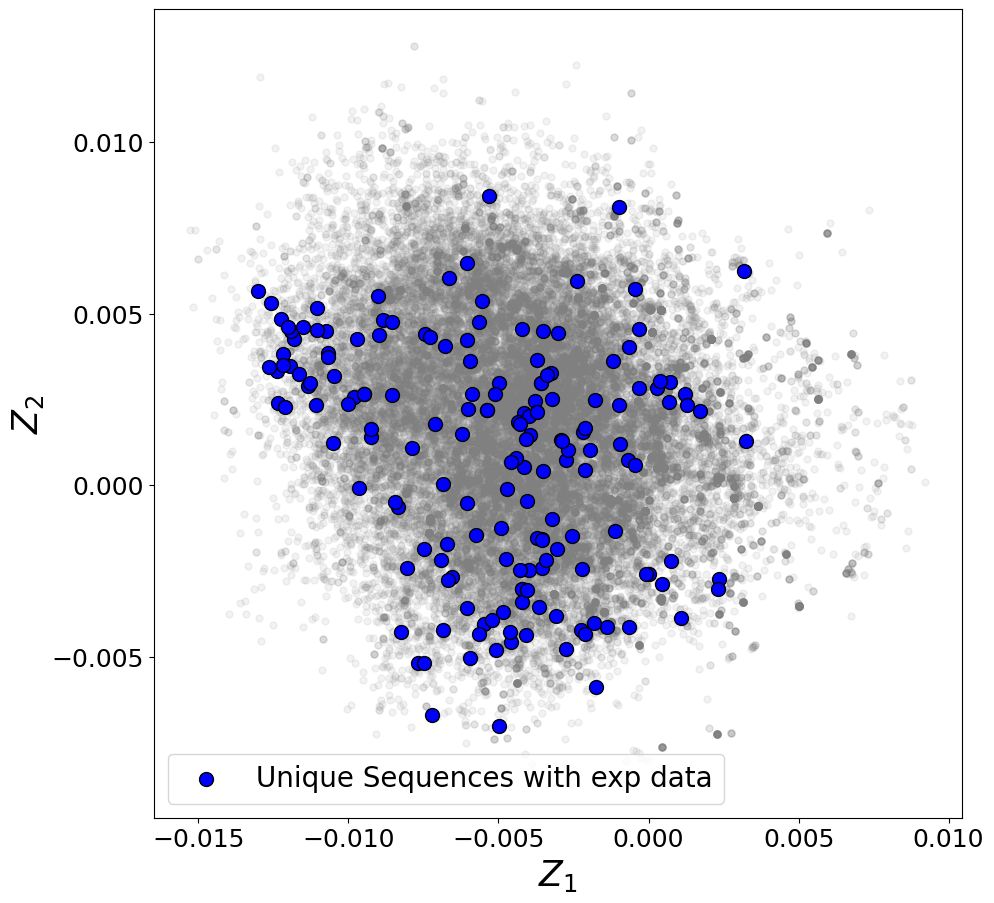

In [67]:
%cd /Users/dahala/GitHub/VAE-enzymes/vae_notebooks
from matplotlib import pyplot as plt
from notebooks.minimal_version.latent_space import LatentSpace
%cd /Users/dahala/GitHub/VAE-enzymes/vae_notebooks/notebooks/

# Projection to the latent space
# Show your queries
run.weights = f'{run.result}/model/vae_fold_0.model'
latent_space = LatentSpace(run)
msa_embeddings = latent_space.msa_embeddings["mus"]


query_coords = latent_space.key_to_embedding(run.fixed_sequences)


fig_lat, ax = plt.subplots(1, 1,figsize=(10,10))

ax.plot(msa_embeddings[:, 0], msa_embeddings[:, 1], '.', alpha=0.1, markersize=10, color='grey',zorder=0)
ax.scatter(mu[:, 0], mu[:, 1], marker='o', s=100, color='blue', label='Unique Sequences with exp data',zorder=1,edgecolors='black')
#ax.scatter(query_coords[0], query_coords[1], marker='o', s=100, color='red', label='Query',zorder=1)

# Project 
ax.legend(loc='lower left', fontsize=20)
ax.tick_params(labelsize=18)
ax.set_xlabel(r'$Z_1$', fontsize=25)
ax.set_ylabel(r'$Z_2$', fontsize=25)
ax.set_box_aspect(1)

plt.tight_layout()
fig_lat.savefig(os.path.join(run.results, f"latent_space_ExpProt.png"))
    #ax.set_title(f"Latent space projection final")

# Benchmark GASPhmm

In [22]:
benchmark_path = '/Users/dahala/GitHub/VAE-enzymes/vae_notebooks/results/Cazy_GT1_trim_200_1000_GASPhmm/benchmark/marginals_benchmark.csv'
benchmark_pd = pd.read_csv(benchmark_path,index_col=0)
benchmark_pd.min().min()

0.1317129840546701

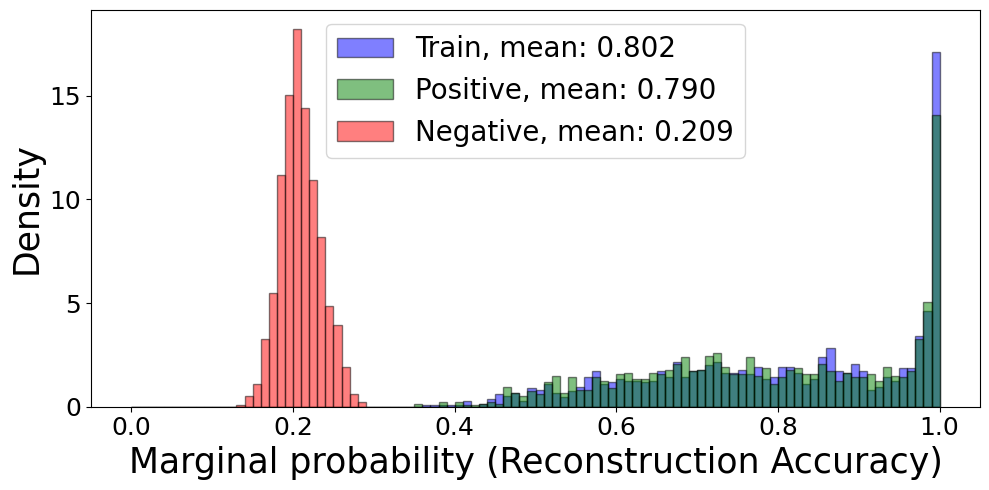

In [23]:
#Plotting the benchmark results

fig_bench, ax = plt.subplots(1, 1,figsize=(10,5))
ax.hist(benchmark_pd['Train'],bins=100,range=(0,1),alpha=0.5,color='blue',edgecolor='black',label=f'Train, mean: {benchmark_pd.Train.mean():.3f}',density=True)
ax.hist(benchmark_pd['Positive'],bins=100,range=(0,1),alpha=0.5,color='green',edgecolor='black',label=f'Positive, mean: {benchmark_pd.Positive.mean():.3f}',density=True)
ax.hist(benchmark_pd['Negative'],bins=100,range=(0,1),alpha=0.5,color='red',edgecolor='black',label=f'Negative, mean: {benchmark_pd.Negative.mean():.3f}',density=True)


ax.set_xlabel('Marginal probability (Reconstruction Accuracy)', fontsize=25)
ax.set_ylabel('Density', fontsize=25)
ax.legend(loc='upper center', fontsize=20)
ax.tick_params(labelsize=18)
#ax.set_title('Benchmark results',fontsize=30)
plt.tight_layout()
fig_bench.savefig(os.path.join(run.results, f"benchmark.png"))

plt.show()

In [24]:
benchmark_ls5_path = '/Users/dahala/GitHub/VAE-enzymes/vae_notebooks/results/Cazy_GT1_trim_200_1000_GASPhmm_ls5/benchmark/marginals_benchmark.csv'
benchmark_ls5_pd = pd.read_csv(benchmark_ls5_path,index_col=0)
benchmark_ls5_pd.min().min()

0.0989339407744878

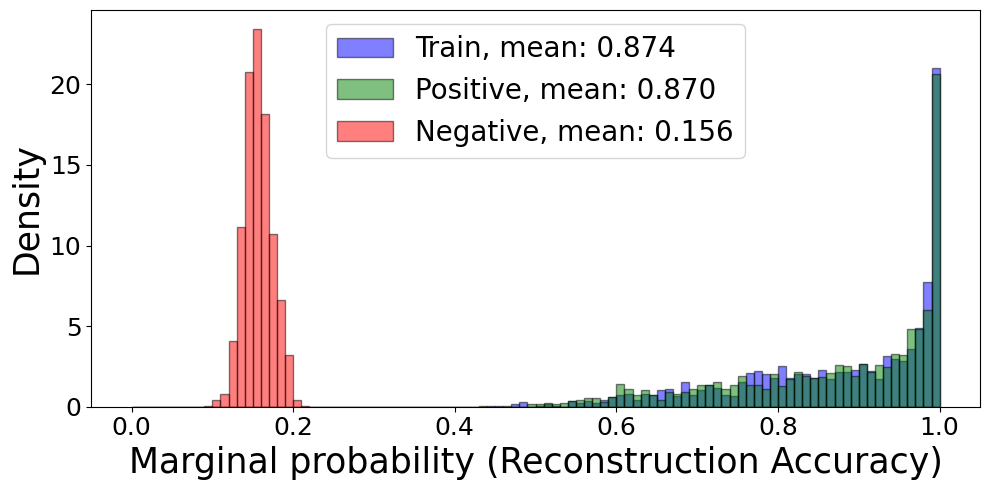

In [25]:
#Plotting the benchmark results

fig_bench, ax = plt.subplots(1, 1,figsize=(10,5))
ax.hist(benchmark_ls5_pd['Train'],bins=100,range=(0,1),alpha=0.5,color='blue',edgecolor='black',label=f'Train, mean: {benchmark_ls5_pd.Train.mean():.3f}',density=True)
ax.hist(benchmark_ls5_pd['Positive'],bins=100,range=(0,1),alpha=0.5,color='green',edgecolor='black',label=f'Positive, mean: {benchmark_ls5_pd.Positive.mean():.3f}',density=True)
ax.hist(benchmark_ls5_pd['Negative'],bins=100,range=(0,1),alpha=0.5,color='red',edgecolor='black',label=f'Negative, mean: {benchmark_ls5_pd.Negative.mean():.3f}',density=True)


ax.set_xlabel('Marginal probability (Reconstruction Accuracy)', fontsize=25)
ax.set_ylabel('Density', fontsize=25)
ax.legend(loc='upper center', fontsize=20)
ax.tick_params(labelsize=18)
#ax.set_title('Benchmark results',fontsize=30)
plt.tight_layout()
fig_bench.savefig(os.path.join(run.results, f"benchmark.png"))

plt.show()

In [26]:
benchmark_ls10_path = '/Users/dahala/GitHub/VAE-enzymes/vae_notebooks/results/Cazy_GT1_trim_200_1000_GASPhmm_ls10/benchmark/marginals_benchmark.csv'
benchmark_ls10_pd = pd.read_csv(benchmark_ls10_path,index_col=0)
benchmark_ls10_pd['Train'].mean()

0.8966906761850514

In [27]:
f'Train, mean: {benchmark_ls10_pd.Train.mean():.3f}'

'Train, mean: 0.897'

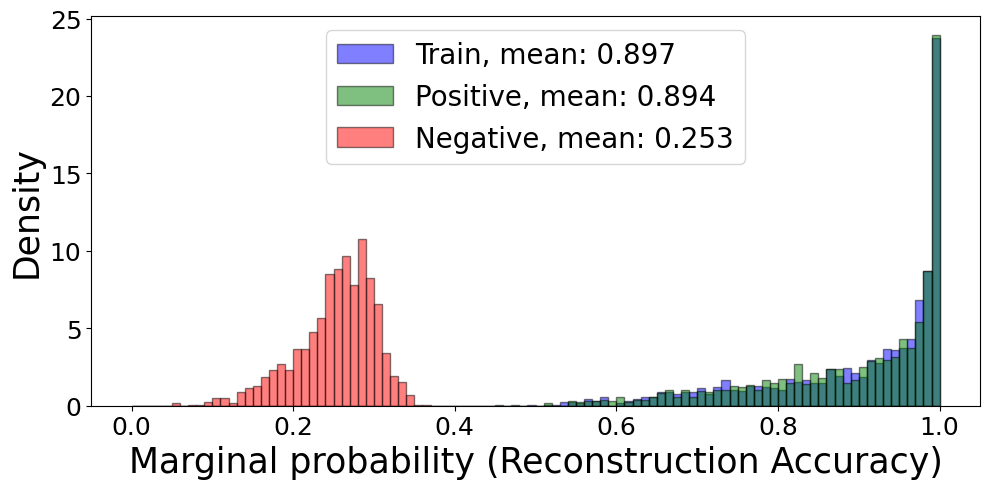

In [28]:
#Plotting the benchmark results

fig_bench, ax = plt.subplots(1, 1,figsize=(10,5))
ax.hist(benchmark_ls10_pd['Train'],bins=100,range=(0,1),alpha=0.5,color='blue',edgecolor='black',label=f'Train, mean: {benchmark_ls10_pd.Train.mean():.3f}',density=True)
ax.hist(benchmark_ls10_pd['Positive'],bins=100,range=(0,1),alpha=0.5,color='green',edgecolor='black',label=f'Positive, mean: {benchmark_ls10_pd.Positive.mean():.3f}',density=True)
ax.hist(benchmark_ls10_pd['Negative'],bins=100,range=(0,1),alpha=0.5,color='red',edgecolor='black',label=f'Negative, mean: {benchmark_ls10_pd.Negative.mean():.3f}',density=True)

ax.set_xlabel('Marginal probability (Reconstruction Accuracy)', fontsize=25)
ax.set_ylabel('Density', fontsize=25)
ax.legend(loc='upper center', fontsize=20)
ax.tick_params(labelsize=18)
#ax.set_title('Benchmark results',fontsize=30)
plt.tight_layout()
fig_bench.savefig(os.path.join(run.results, f"benchmark.png"))

plt.show()

In [68]:
benchmark_path = '/Users/dahala/GitHub/VAE-enzymes/vae_notebooks/results/Cazy_GT1_trim_200_1000_GASPhmm/logs/train_log.txt'
benchmark_pd = pd.read_csv(benchmark_path,skiprows=3,skipfooter=16,header=None,engine='python',sep='\s+')[[3,5]]
benchmark_pd[3] = benchmark_pd[3].str.replace(',','').astype(float)
benchmark_path = '/Users/dahala/GitHub/VAE-enzymes/vae_notebooks/results/Cazy_GT1_trim_200_1000_GASPhmm_ls5/logs/train_log.txt'
benchmark_ls5_pd = pd.read_csv(benchmark_path,skiprows=3,skipfooter=16,header=None,engine='python',sep='\s+')[[3,5]]
benchmark_ls5_pd[3] = benchmark_ls5_pd[3].str.replace(',','').astype(float)
benchmark_path = '/Users/dahala/GitHub/VAE-enzymes/vae_notebooks/results/Cazy_GT1_trim_200_1000_GASPhmm_ls10/logs/train_log.txt'
benchmark_ls10_pd = pd.read_csv(benchmark_path,skiprows=3,skipfooter=16,header=None,engine='python',sep='\s+')[[3,5]]
benchmark_ls10_pd[3] = benchmark_ls10_pd[3].str.replace(',','').astype(float)
benchmark_path = '/Users/dahala/GitHub/VAE-enzymes/vae_notebooks/results/Cazy_GT1_trim_200_1000_GASPhmm_lay400to200_ls100/logs/train_log.txt'
benchmark_lay400to200_ls100_pd = pd.read_csv(benchmark_path,skiprows=3,skipfooter=16,header=None,engine='python',sep='\s+')[[3,5]]
benchmark_lay400to200_ls100_pd[3] = benchmark_lay400to200_ls100_pd[3].str.replace(',','').astype(float)

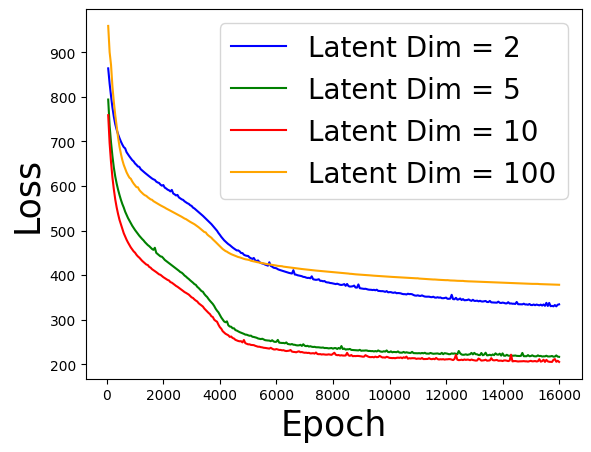

In [69]:
plt.plot(benchmark_pd[3],benchmark_pd[5],label='Latent Dim = 2',color='blue')
plt.plot(benchmark_ls5_pd[3],benchmark_ls5_pd[5],label='Latent Dim = 5',color='green')
plt.plot(benchmark_ls10_pd[3],benchmark_ls10_pd[5],label='Latent Dim = 10',color='red')
plt.plot(benchmark_lay400to200_ls100_pd[3],benchmark_lay400to200_ls100_pd[5],label='Latent Dim = 100',color='orange')
plt.xlabel('Epoch',fontsize=25)
plt.ylabel('Loss',fontsize=25)
plt.legend(loc='upper right', fontsize=20)


# Benchmark CharactNArch

In [31]:
benchmark_path = '/Users/dahala/GitHub/VAE-enzymes/vae_notebooks/results/Cazy_GT1_trim_200_1000_charactNarch/benchmark/marginals_benchmark.csv'
benchmark_pd = pd.read_csv(benchmark_path,index_col=0)
benchmark_pd.min().min()

0.1502183622828789

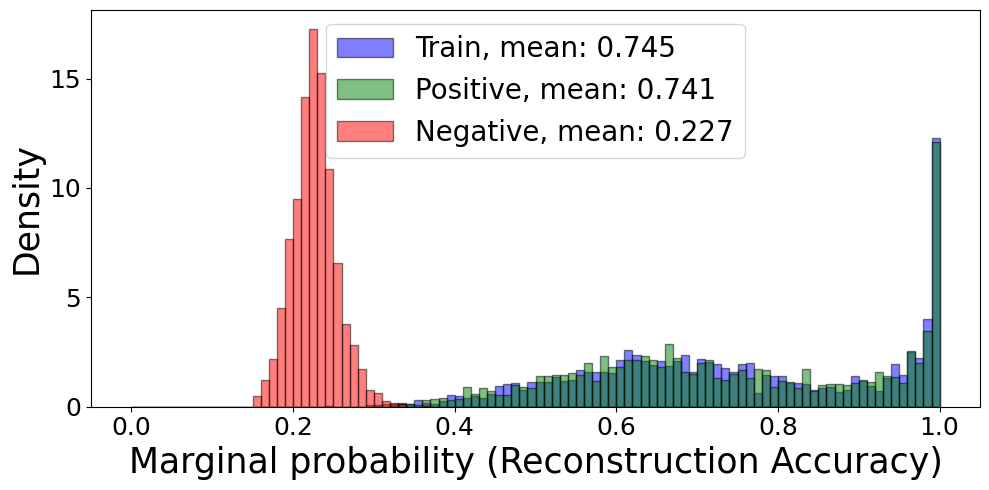

In [32]:
#Plotting the benchmark results

fig_bench, ax = plt.subplots(1, 1,figsize=(10,5))
ax.hist(benchmark_pd['Train'],bins=100,range=(0,1),alpha=0.5,color='blue',edgecolor='black',label=f'Train, mean: {benchmark_pd.Train.mean():.3f}',density=True)
ax.hist(benchmark_pd['Positive'],bins=100,range=(0,1),alpha=0.5,color='green',edgecolor='black',label=f'Positive, mean: {benchmark_pd.Positive.mean():.3f}',density=True)
ax.hist(benchmark_pd['Negative'],bins=100,range=(0,1),alpha=0.5,color='red',edgecolor='black',label=f'Negative, mean: {benchmark_pd.Negative.mean():.3f}',density=True)


ax.set_xlabel('Marginal probability (Reconstruction Accuracy)', fontsize=25)
ax.set_ylabel('Density', fontsize=25)
ax.legend(loc='upper center', fontsize=20)
ax.tick_params(labelsize=18)
#ax.set_title('Benchmark results',fontsize=30)
plt.tight_layout()
fig_bench.savefig(os.path.join(run.results, f"benchmark.png"))

plt.show()

In [70]:
benchmark_path = '/Users/dahala/GitHub/VAE-enzymes/vae_notebooks/results/Cazy_GT1_trim_200_1000_charactNarch/logs/train_log.txt'
benchmark_pd = pd.read_csv(benchmark_path,skiprows=3,skipfooter=21,header=None,engine='python',sep='\s+')[[3,5]]
benchmark_pd[3] = benchmark_pd[3].str.replace(',','').astype(float)
benchmark_path = '/Users/dahala/GitHub/VAE-enzymes/vae_notebooks/results/Cazy_GT1_trim_200_1000_charactNarch_ls5/logs/train_log.txt'
benchmark_ls5_pd = pd.read_csv(benchmark_path,skiprows=3,skipfooter=21,header=None,engine='python',sep='\s+')[[3,5]]
benchmark_ls5_pd[3] = benchmark_ls5_pd[3].str.replace(',','').astype(float)
benchmark_path = '/Users/dahala/GitHub/VAE-enzymes/vae_notebooks/results/Cazy_GT1_trim_200_1000_charactNarch_ls10/logs/train_log.txt'
benchmark_ls10_pd = pd.read_csv(benchmark_path,skiprows=3,skipfooter=21,header=None,engine='python',sep='\s+')[[3,5]]
benchmark_ls10_pd[3] = benchmark_ls10_pd[3].str.replace(',','').astype(float)
benchmark_path = '/Users/dahala/GitHub/VAE-enzymes/vae_notebooks/results/Cazy_GT1_trim_200_1000_charactNarch_lay400to200_ls100/logs/train_log.txt'
benchmark_lay400to200_ls100_pd = pd.read_csv(benchmark_path,skiprows=3,skipfooter=21,header=None,engine='python',sep='\s+')[[3,5]]
benchmark_lay400to200_ls100_pd[3] = benchmark_lay400to200_ls100_pd[3].str.replace(',','').astype(float)

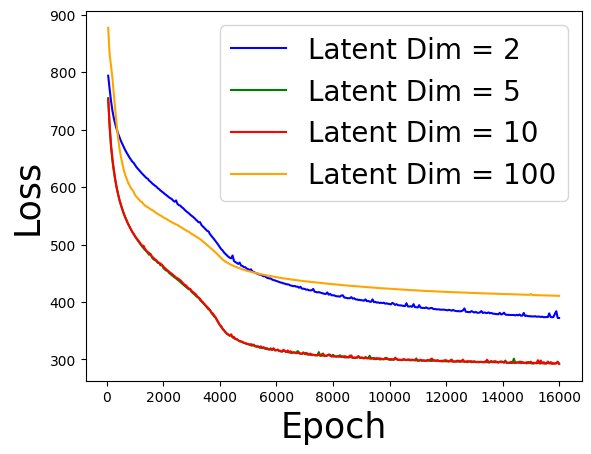

In [71]:
plt.plot(benchmark_pd[3],benchmark_pd[5],label='Latent Dim = 2',color='blue')
plt.plot(benchmark_ls5_pd[3],benchmark_ls5_pd[5],label='Latent Dim = 5',color='green')
plt.plot(benchmark_ls10_pd[3],benchmark_ls10_pd[5],label='Latent Dim = 10',color='red')
plt.plot(benchmark_lay400to200_ls100_pd[3],benchmark_lay400to200_ls100_pd[5],label='Latent Dim = 100',color='orange')
plt.xlabel('Epoch',fontsize=25)
plt.ylabel('Loss',fontsize=25)
plt.legend(loc='upper right', fontsize=20)